### <span style="color:blue">Packages</span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr
import seaborn as sns

### <span style="color:blue">Functions</span>

In [2]:
# Functions

def Gaussian(p,x):
    Gaussian = np.exp(-0.5*((x-p[0])/p[1])**2)
    return Gaussian

def Lorentzian(p,x):
    Lorentzian = (p[1]**2)/((x-p[0])**2+p[1]**2)
    return Lorentzian

def VDOS_Gauss(num_freq , freq, inty): 
    '''
    the arguments are number of frequencies (num_freq), frequencies (freq) and intensities (inty)
    '''
    VDOS=np.empty((nstep,num_freq))
    for j in range(num_freq):
        p = [freq[j],sigma]
        VDOS[:,j] = Gaussian(p,x)*inty[j]
    
    VDOS_sum = np.sum(VDOS,axis=1)
    
    return VDOS_sum

# Function to calculate Euclidean similarity
def euclidean_similarity(spectrum1, spectrum2):
    distance = euclidean(spectrum1, spectrum2)
    similarity = 1 / (1 + distance)  # Convert distance to similarity
    return similarity

# Function to calculate Cosine similarity
def cosine_similarity(spectrum1, spectrum2):
    similarity = 1 - cosine(spectrum1, spectrum2)  # Convert distance to similarity
    return similarity

# Function to calculate Pearson correlation
def pearson_similarity(spectrum1, spectrum2):
    correlation, _ = pearsonr(spectrum1, spectrum2)
    return correlation

def find_high_similarity_groups(similarity_matrix, threshold):
    n = similarity_matrix.shape[0]  # Number of items
    visited = [False] * n           # Keep track of visited nodes
    groups = []                     # Store the groups

    def dfs(node, group):
        visited[node] = True
        group.append(node)
        for neighbor in range(n):
            if not visited[neighbor] and similarity_matrix[node, neighbor] > threshold:
                dfs(neighbor, group)

    # Iterate over all items
    for i in range(n):
        if not visited[i]:
            group = []
            dfs(i, group)
            if len(group) > 1:  # Only consider groups of more than 1 item
                groups.append(group)

    return groups

### <span style="color:blue"> Data </span>

In [3]:
# Number of vibrational spectra
n = 25

# Variables
Frequencies = []
IR = []

for i in range(n):
    Freq = np.array(np.loadtxt(f"Freq_{i}.txt",dtype=np.float64))
    Int = np.array(np.loadtxt(f"IR_{i}.txt",dtype=np.float64))
    Frequencies.append(Freq)
    IR.append(Int)
    

### <span style="color:blue">Parameters</span>

In [4]:
sigma = 11  # width of the Gaussian function
n = len(Frequencies)
Fmax = 2200  # maximum of frequency
Fmin = 400  # minimum of frequency
step = 1
nstep = int(round((Fmax-Fmin)/step)+1)

# x values are equal to all molecules
x = []
for i in range(nstep):
    x.append(Fmin + step*i)
x = np.array(x)

### <span style="color:blue">IR calculation</span>

In [5]:
for i in range(n):
    var_name = f'IR{i}'
    # Assign the array to the dynamic global variable
    globals()[var_name] = VDOS_Gauss(len(Frequencies[i]), Frequencies[i], IR[i])

IR_spectra = []
for i in range(n):
    Inten = VDOS_Gauss(len(Frequencies[i]), Frequencies[i], IR[i])
    IR_spectra.append(Inten)

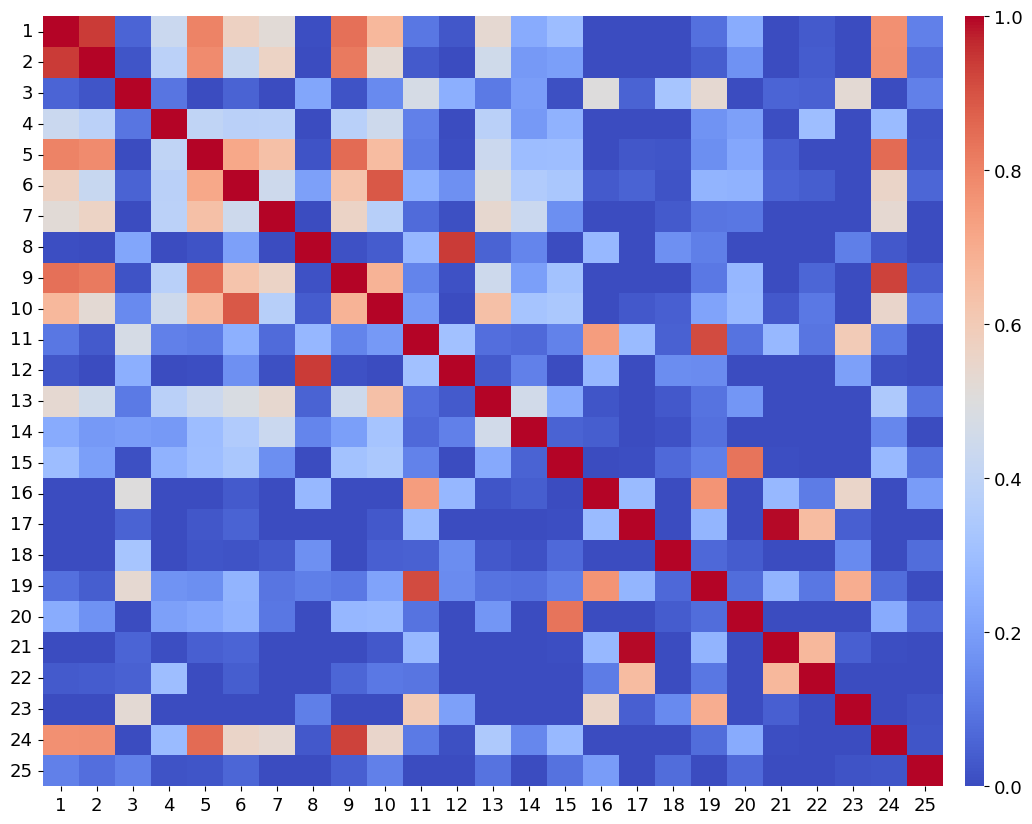

In [6]:
# Building the similarity matrix

n_comp = len(IR_spectra)

pearson_total = np.zeros((n_comp, n_comp))

for i in range(n_comp):
    for j in range(n_comp):
        pearson_total[i, j] = pearson_similarity(IR_spectra[i], IR_spectra[j])
        
plt.figure(figsize=(14,10))

ax = sns.heatmap(pearson_total, vmin=0.00, vmax=1.00, cmap="coolwarm",cbar_kws={"aspect": 40,"pad": 0.02})
ax.set_xticklabels([int(label.get_text()) + 1 for label in ax.get_xticklabels()], fontsize=13)
ax.set_yticklabels([int(label.get_text()) + 1 for label in ax.get_yticklabels()], fontsize=13, rotation=0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=13) 

In [7]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(6, affinity='precomputed',assign_labels='discretize')
sc.fit_predict(pearson_total)  
labels= sc.fit_predict(pearson_total)  

# Get unique cluster labels
unique_labels = np.unique(labels)

# Create a dictionary to store indices of each cluster
cluster_dict = {label: np.where(labels == label)[0] for label in unique_labels}

# Convert to arrays if you need
cluster_arrays = [cluster_dict[label] for label in unique_labels]

# Print each cluster array
for i, cluster in enumerate(cluster_arrays):
    print(f"Cluster {i} indices:", cluster)

Cluster 0 indices: [ 0  1  3  4  5  6  8  9 12 13 23]
Cluster 1 indices: [ 7 11]
Cluster 2 indices: [10 15 18 22]
Cluster 3 indices: [16 20 21]
Cluster 4 indices: [14 19]
Cluster 5 indices: [ 2 17 24]


In [8]:
from sklearn.metrics import silhouette_score
import numpy as np

# Step 1: Convert Pearson similarity to a distance matrix
# Since Pearson ranges from -1 to 1, we map it to distance: d = 1 - similarity
pearson_distance = 1 - pearson_total

# Step 2: Compute Silhouette Score using precomputed distances
sil_score = silhouette_score(pearson_distance, labels, metric='precomputed')

print("Silhouette Score:", sil_score)


Silhouette Score: 0.48046449850456613


In [9]:
from sklearn.cluster import SpectralClustering

n_comp = len(IR_spectra)
pearson_total = np.zeros((n_comp, n_comp))

for i in range(n_comp):
    for j in range(n_comp):
        pearson_total[i, j] = pearson_similarity(IR_spectra[i], IR_spectra[j])

sc = SpectralClustering(8, affinity='precomputed', assign_labels='discretize')
labels = sc.fit_predict(pearson_total)

In [10]:
import networkx as nx

# Convert Pearson similarity matrix to graph (weighted undirected)
G = nx.from_numpy_array(pearson_total)

In [11]:
# Build partition: dict {node: cluster_label}
partition = {i: label for i, label in enumerate(labels)}

In [12]:
import community as community_louvain  # pip install python-louvain

modularity_score = community_louvain.modularity(partition, G)
print("Modularity Score:", modularity_score)

Modularity Score: 0.41461547554529965


In [24]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(6, affinity='precomputed',assign_labels='discretize')
labels= sc.fit_predict(pearson_total)  

# Get unique cluster labels
unique_labels = np.unique(labels)

# Create a dictionary to store indices of each cluster
cluster_dict = {label: np.where(labels == label)[0] for label in unique_labels}

# Convert to arrays if you need
cluster_arrays = [cluster_dict[label] for label in unique_labels]

# Print each cluster array
for i, cluster in enumerate(cluster_arrays):
    print(f"Cluster {i} indices:", cluster)

Cluster 0 indices: [ 7 11]
Cluster 1 indices: [10 15 18 22]
Cluster 2 indices: [ 0  1  3  4  5  6  8  9 12 13 23]
Cluster 3 indices: [16 20 21]
Cluster 4 indices: [14 19]
Cluster 5 indices: [ 2 17 24]


In [25]:
from sklearn.metrics import silhouette_score
import numpy as np

# Step 1: Convert Pearson similarity to a distance matrix
# Since Pearson ranges from -1 to 1, we map it to distance: d = 1 - similarity
pearson_distance = 1 - pearson_total

# Step 2: Compute Silhouette Score using precomputed distances
sil_score = silhouette_score(pearson_distance, labels, metric='precomputed')

print("Silhouette Score:", sil_score)


Silhouette Score: 0.48046449850456613


In [28]:
odor_labels = [
"F",
"W",
"S",
"L",
"P",
"W",
"P",
"P",
"W",
"F",
"F",
"P",
"L",
"P",
"G",
"S",
"D",
"S",
"S",
"G",
"D",
"D",
"S",
"F",
"D"
]

In [29]:
from sklearn.metrics import adjusted_mutual_info_score

odor_labels = np.array(odor_labels).flatten()

print("AMI:", adjusted_mutual_info_score(odor_labels, labels))

AMI: 0.43806087926650916
